# Library

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import zipfile

from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU,MaxPooling2D, UpSampling2D, Cropping2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim

SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
import random
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# Read Dataset

In [2]:
path_kirmizi = 'B_23/kirmizi'
path_siirt = 'B_23/siirt'

img_kirmizi = []
img_siirt = []

for root, dirs, files in os.walk(path_kirmizi):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_kirmizi.append(os.path.join(root, file))

for root, dirs, files in os.walk(path_siirt):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_siirt.append(os.path.join(root, file))

In [3]:
for dirpath, dirnames, filenames in os.walk("B_23"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'B_23'.
There are 0 directories and 616 images in 'B_23\kirmizi'.
There are 0 directories and 458 images in 'B_23\siirt'.


# EDA

In [4]:
def display_sample(image_list, title_prefix="Images"):
    n = min(5, len(image_list))
    plt.figure(figsize=(10, 5))
    plt.suptitle(title_prefix, fontsize=14,y=0.75)

    for i in range(n):
        img_path = image_list[i]
        img = Image.open(img_path).convert('RGB')
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"Sample {i + 1}")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

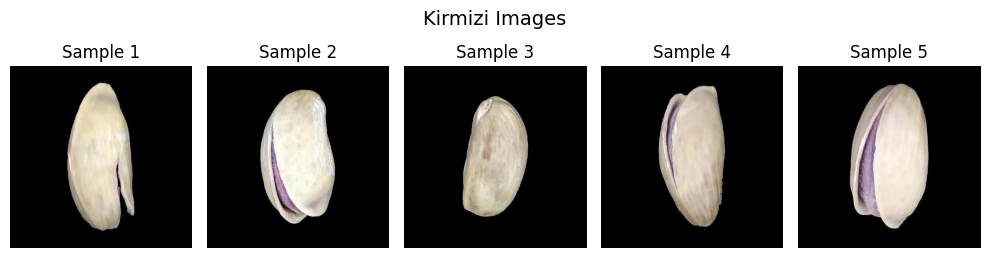

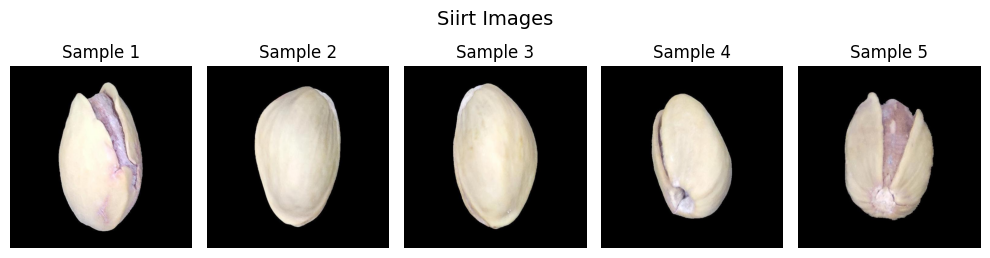

In [ ]:
display_sample(img_kirmizi, title_prefix="Kirmizi Images")
display_sample(img_siirt, title_prefix="Siirt Images")

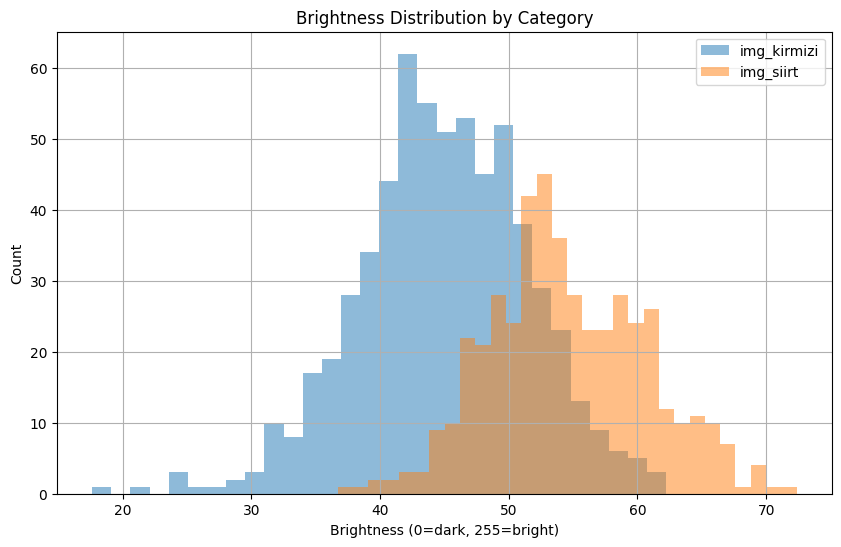

In [5]:
image_paths = {
    "img_kirmizi": img_kirmizi,
    "img_siirt": img_siirt
}

def analyze_brightness_combined(image_paths_by_category):
    plt.figure(figsize=(10, 6))

    for category, paths in image_paths_by_category.items():
        brightness_values = []
        for img_path in paths:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            brightness = np.array(img).mean()
            brightness_values.append(brightness)

        plt.hist(brightness_values, bins=30, alpha=0.5, label=category)

    plt.title('Brightness Distribution by Category')
    plt.xlabel('Brightness (0=dark, 255=bright)')
    plt.ylabel('Count')
    plt.grid(True)
    plt.legend()
    plt.show()

analyze_brightness_combined(image_paths)

img_kirmizi (biru) : 
- Rata-rata kecerahan berkisar antara 40–50
- Lebih banyak gambar yang cenderung lebih gelap dibanding img_siirt

img_siirt (orange):
- Rata-rata kecerahan bergeser ke kanan, di kisaran 50–60
- Secara keseluruhan lebih terang dibanding img_kirmizi

Mengapa ini penting :
- Perbedaan distribusi ini menegaskan bahwa img_kirmizi dan img_siirt punya karakteristik visual yang berbeda, khususnya dalam aspek pencahayaan atau dominasi warna.
- Jika model klasifikasi memberikan hasil akurat, kita bisa melihat bahwa kecerahan mungkin berkontribusi kuat dalam pembeda antar kelas.
- Sebaliknya, jika model overfit, kita tahu mungkin dia hanya “belajar” dari pencahayaan, bukan fitur sejati.





# Image Characteristics

In [31]:
dimensions = []
data_types = []
num_nChannels = []
img_all = img_kirmizi + img_siirt

for i, img_path in enumerate(img_all):
    img = Image.open(img_path).convert('RGB')
    img_array = np.array(img)
    
    dimensions.append(img_array.shape[:2])
    data_types.append(img_array.dtype)
    num_nChannels.append(img_array.shape[2] if img_array.ndim == 3 else 1)

In [32]:
unique_dimensions = set(dimensions)
print(f"All dimensions: {unique_dimensions}")
unique_data_types = set(data_types)
print(f"All data types: {unique_data_types}")
unique_nChannels = set(num_nChannels)
print(f"All nChannels: {unique_nChannels}")

All dimensions: {(600, 600)}
All data types: {dtype('uint8')}
All nChannels: {3}


# Resize


In [34]:
IMG_SIZE = (100, 100)
img_processed = []

for i, img_path in enumerate(img_all):
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(IMG_SIZE)
    img_array = np.array(img_resized)
    
    img_normalized = img_array.astype('float32') / 255.0
    img_processed.append(img_normalized)

img_processed = np.array(img_processed)

# Train Test Val Split

In [35]:
X_train, X_temp = train_test_split(img_processed, test_size=0.2, random_state=354)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=354)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(859, 100, 100, 3)
(107, 100, 100, 3)
(108, 100, 100, 3)


# Add Noise

In [ ]:
def addNoise(img, mean=0.0, std_dev=0.1):
    noise = np.random.normal(mean, std_dev, img.shape)
    img_noisy = img + noise
    img_noisy = np.clip(img_noisy, 0.0, 1.0)
    return img_noisy

x_train = addNoise(X_train)
x_val = addNoise(X_val)
x_test = addNoise(X_test)

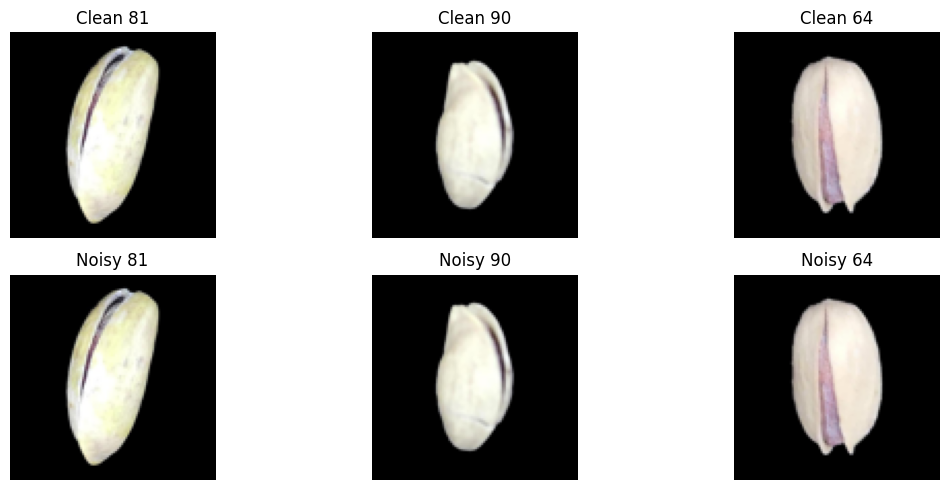

In [ ]:
plt.figure(figsize=(12, 5))

for i in range(3):
    idx = np.random.randint(0, len(X_test))

    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Clean {idx}")
    plt.axis('off')

    plt.subplot(2, 3, i + 3 + 1)
    plt.imshow(x_test[idx])
    plt.title(f"Noisy {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(859, 100, 100, 3)
(107, 100, 100, 3)
(108, 100, 100, 3)


# Callbacks

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Model Autoencoder

In [ ]:
input_img = Input(shape=(100, 100, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)           
x = MaxPooling2D((2, 2), padding='same')(x)                                   
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)                   
x = MaxPooling2D((2, 2), padding='same')(x)                                       
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)                       

x = UpSampling2D((2, 2))(x)                                                        
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)                       
x = UpSampling2D((2, 2))(x)                                                       
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  

baseline = Model(input_img, decoded)
baseline.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
baseline.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = baseline.fit(
    x_train,           
    x_train,                
    epochs=50,
    batch_size=32,
    validation_data=(x_val, x_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.4439 - loss: 0.1282 - val_accuracy: 0.2471 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.2472 - loss: 0.0131 - val_accuracy: 0.2216 - val_loss: 0.0816 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.2149 - loss: 0.0383 - val_accuracy: 0.2762 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.2555 - loss: 0.0141 - val_accuracy: 0.2305 - val_loss: 0.0138 - learning_rate: 5.0000e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.2296 - loss: 0.0133 - val_accuracy: 0.2278 - val_loss: 0.0132 - learning_rate: 5.0000e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.2238 - loss: 0.0127 - val_accuracy: 0.2290 - val_loss: 0.0126 - learning_rate: 5.0000e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.2257 - los

# Modified Autoencoder

In [41]:
input_mod = Input(shape=(100, 100, 3))

x = Conv2D(32, (3, 3), padding='same')(input_mod)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = Cropping2D(cropping=((2, 2), (2, 2)))(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_modified = Model(input_mod, x)
autoencoder_modified.compile(optimizer=Adam(), loss='mse')
autoencoder_modified.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 26, 26, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 104, 104, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_1 (Cropping2D)       │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history_modified = autoencoder_modified.fit(x_train, x_train,
                                             epochs=50,
                                             batch_size=32,
                                             shuffle=True,
                                             validation_data=(x_val, x_val))

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - loss: 0.0984 - val_loss: 0.0162
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.0154 - val_loss: 0.0118
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.0099 - val_loss: 0.0050
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step

# Evaluation

In [43]:
denoised_baseline = baseline.predict(X_test)
ssim_baseline = []

for i in range(len(X_test)):
    score = ssim(X_test[i], denoised_baseline[i], data_range=1.0, channel_axis=-1)
    ssim_baseline.append(score)

mean_ssim_baseline = np.mean(ssim_baseline)
print(f"Baseline Mean SSIM: {mean_ssim_baseline:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Baseline Mean SSIM: 0.8889


In [44]:
denoised_modified = autoencoder_modified.predict(X_test)
ssim_modified = []

for i in range(len(X_test)):
    score = ssim(X_test[i], denoised_modified[i], data_range=1.0, channel_axis=-1)
    ssim_modified.append(score)

mean_ssim_modified = np.mean(ssim_modified)
print(f"Modified Mean SSIM: {mean_ssim_modified:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Modified Mean SSIM: 0.9432


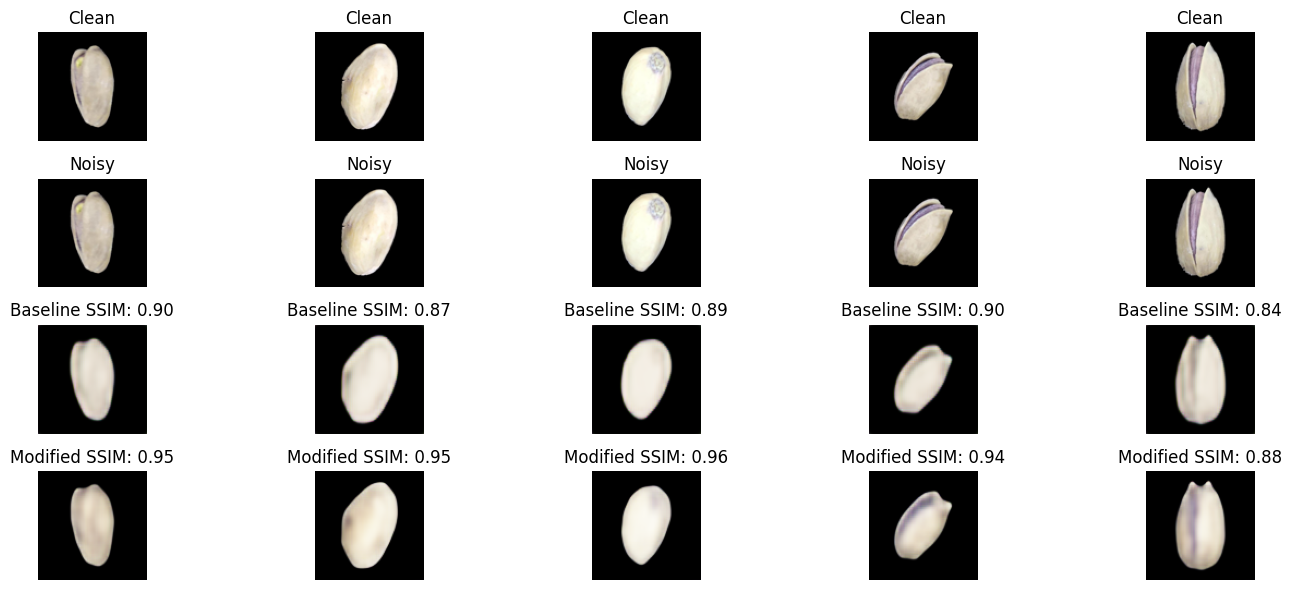

In [45]:
n=5
plt.figure(figsize=(15, 6))

for i in range(n):
    idx = np.random.randint(0, len(X_test))

    # Clean
    plt.subplot(4, n, i + 1)
    plt.imshow(X_test[idx])
    plt.title("Clean")
    plt.axis('off')

    # Noisy
    plt.subplot(4, n, i + n + 1)
    plt.imshow(X_test[idx])
    plt.title("Noisy")
    plt.axis('off')

    # Denoised - Baseline
    plt.subplot(4, n, i + (2 * n) + 1)
    plt.imshow(denoised_baseline[idx])
    plt.title(f"Baseline SSIM: {ssim_baseline[idx]:.2f}")
    plt.axis('off')

    # Denoised - Modified
    plt.subplot(4, n, i + (3 * n) + 1)
    plt.imshow(denoised_modified[idx])
    plt.title(f"Modified SSIM: {ssim_modified[idx]:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

- Model modifikasi secara konsisten menghasilkan gambar dengan SSIM lebih tinggi dari baseline. 
- SSIM meningkat dari rata-rata baseline 0.88 ke hasil modifikasi 0.94. Ini menunjukkan bahwa model modifikasi lebih baik dalam merekonstruksi gambar bersih dari gambar noisy, baik dari segi struktur, tekstur, dan kualitas visual. 
- Hasil visual juga mendukung metriknya: gambar hasil denoising modifikasi tampak lebih halus dan mirip dengan gambar asli dibanding baseline.